In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
from scipy import special
import healpy as hp
import os
import imageio
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"})

In [2]:
def temporalPlot(pt,Nt,gaps):
    tbeg, tend = 1717.6256+(np.linspace(1666.4384902198801, 2704.3655735533684, 2) + 2455197.5 - 2457023.5 - 0.25)*4
    bins = np.linspace(tbeg,tend,Nt+1)
    centres = 0.5*(bins[1:] + bins[:-1])

    plt.plot(centres,pt)
    
    if type(gaps) != bool:
        for start,end in zip(gaps['tbeg'].values,gaps['tend'].values):
            plt.fill_between([start,end],y1=[-2,-2],y2=[2,2],color='lightblue',lw=0.0)
    plt.ylim([0,1.02])
   
    plt.xlabel(r"OBMT (revolutions)")
    plt.ylabel(r"$p_t$")
    plt.title(r"Temporal Detection Efficiency")
    plt.xticks(np.arange(1000,5251,1000))

    plt.yticks(np.arange(0.0,1.01,0.1))
    # plt.grid(axis='both',which='both',lw=0.3,color='lightgrey',zorder=0)
    # plt.savefig(directory+'plot_pt.png',dpi=300,facecolor='w',bbox_inches='tight')
  

In [3]:
def temporalResiduals(pt,pt_true):
    
    deltas = np.absolute(pt - pt_true) + 1e-8
   # deltas[np.isinf(deltas) or np.isnan(deltas) or deltas < -8] = -8
    logDeltas = np.log10(deltas)
    plt.hist(logDeltas,bins = 100, histtype='step',log = True)
    
    plt.xlabel(r"$\log_{10}\left( \left|p_t^{true} - p_t^{recovered} \right|\right)$")
    plt.ylabel(r"Counts")
    
    lowerLim = np.floor(min(logDeltas))
    plt.xlim([lowerLim,0])
    plt.title(r"Temporal Residuals")

In [4]:
def round_sig(x, sig=2):
    return round(x, sig-int(np.floor(np.log10(abs(x))))-1)
def spatialPlot(pml,titleText,fig,manualScaling = False):
    mi = 0
    ma = 1
    if manualScaling:
        v = round_sig(max(abs(pml)),2)
        mi = -v
        ma = v

    hp.mollview(pml, xsize = 500,nest=False, hold=True, min=mi,max=ma,title =titleText, cmap='viridis', cbar=True,coord=['C','G'],notext=True,unit=r"$p_{ml}$")
    hp.graticule(dmer=360,dpar=360,alpha=0)  

In [16]:
def readFile(directory,file):
    try:
        params = pd.read_csv(directory+'OptimizerProperties.dat',skipinitialspace=True,index_col=0,sep=" =",header=None,engine='python').transpose()
        Nt = int(params['Nt'])
        Nm = int(params['Nm'])
        Nl = int(params['Nl'])
    except:
        params = pd.read_csv(directory+'Optimiser_Properties.dat',skipinitialspace=True,sep=",")
        Nt = int(params['Nt'])
        Nm = int(params['Nm'])
        Nl = int(params['Nl'])
    alpha = 0.5*np.log(2)
    a = -3.0
    if type(file) == int:
        file = "TempPositions/TempPosition" + str(file) + "_TransformedParameters.dat"
    xt = pd.read_csv(directory+file,header=None)[0][:Nt].values
    pt = special.expit(xt)
    xml = np.reshape(pd.read_csv(directory+file,header=None)[0][Nt:Nt+Nm*Nl].values,(Nl,Nm)).T
    pml = np.exp(-2.0*alpha*np.exp(-xml))
    pml[xml<a] = np.exp(-2.0*alpha*(1.0-xml[xml<a]+a)*np.exp(-a))
    return [pt,pml,Nm]

In [6]:
def baseGif(saveName,truedirectory,tempdirectory,start,stop):
    
    trueFile = "True_TransformedParameters.dat"
    [truePt,truePml] = readFile(truedirectory,trueFile)
    names = []
    fig = plt.figure(figsize=(8,8))
    for i in range(start,stop,gap):
        print(i)
        [pt,pml] = readFile(directory,i)

        baseComparisonPlot(fig,truePt,truePml,pt,pml,False)

        tempName = saveName +"_temp" + str(i) + ".png"
        names.append(tempName)
        plt.savefig(tempName)
        fig.clf()
    plt.close(fig)
 
    saveName = saveName + ".gif"
    delay = 2
    with imageio.get_writer(saveName,mode = 'I') as writer:
        for name in names:
            print(name)
            image = imageio.imread(name)
            for k in range(0,delay):
                writer.append_data(image)

            os.remove(name)

In [40]:
def magnitudePlot(mag,trueMag):
    Nm = len(mag)
    Nm_t = len(trueMag)
    bins = np.arange(1.7,23.05,0.1)
    
    if Nm_t > 1:
        g = 0.5*(bins[1:]+bins[:-1])[:Nm_t]
        
        plt.plot(g,trueMag)
    else:
        plt.plot([bins[0],bins[-1]],[trueMag[0],trueMag[0]])
    if Nm > 1:
        
        g = 0.5*(bins[1:]+bins[:-1])[:Nm]
        
        plt.plot(g,mag)
    else:
        plt.plot([bins[0],bins[-1]],[mag[0],mag[0]])
    plt.legend(["True Value","Recovered Value"],loc="lower center")
    plt.xlabel(r"$G$, Visual Magnitude")
    plt.ylabel(r"Sky-Averaged Probability")
    plt.title("Magnitude Probability")

In [29]:
def baseComparisonPlot(fig,truept,truepml,pt,pml,gaps,Nm_true,Nm):
 
    ##temporal plot
   
    nx = 2
    ny = 3
    magPlot = False
    if max(Nm_true,Nm) > 1:
        ny += 1
        magPlot = True
    gs = GridSpec(ny,nx)

    tpml = truepml[0]
    trueMag = [np.mean(tpml)]
    for m in range(1,Nm_true):
        tpml += truepml[m]
        trueMag.append(np.mean(truepml[m]))
    tpml /= Nm_true
    
    apml = pml[0]
    mag = [np.mean(apml)]
    for m in range(1,Nm):
        apml += pml[m]
        mag.append(np.mean(pml[m]))
    apml /= Nm

    nside_true = hp.get_nside(tpml)
    nside_approx = hp.get_nside(apml)
   
    if nside_true != nside_approx:
        if nside_true > nside_approx:
            apml = hp.ud_grade(apml,nside_true)
        else:
            tpml = hp.ud_grade(tpml,nside_approx)
    
    ##spatial plot
    fig.add_subplot(gs[1,0])
    spatialPlot(tpml,"True Spatial Efficiency",fig)
    fig.add_subplot(gs[1,1])
    spatialPlot(apml,"Recovered Spatial Efficiency",fig)
    fig.add_subplot(gs[2,1])
    spatialPlot(tpml-apml,"Spatial Residuals",fig,True)
    

    fig.add_subplot(gs[0,:])
    temporalPlot(truept,len(truept),False)

    temporalPlot(pt,len(pt),False)
    plt.legend(["True Value","Recovered Value"],loc="lower right")
    

    fig.add_subplot(gs[2,0])
    temporalResiduals(pt,truept)
    
    if magPlot:
        fig.add_subplot(gs[3,:])
        magnitudePlot(mag,trueMag)

In [15]:
def baseFrame(saveName,truedirectory,tempdirectory,frame):
    trueFile = "True_TransformedParameters.dat"
    [truePt,truePml,Nm_true] = readFile(truedirectory,trueFile)
    # [truePt,truePml] = readFile(tempdirectory,frame - 10)
    fig = plt.figure(figsize=(8,8),dpi = 200)

    
    
    [pt,pml,Nm] = readFile(tempdirectory,frame)


    baseComparisonPlot(fig,truePt,truePml,pt,pml,False,Nm_true,Nm)

    # fig.tight_layout()
    plt.savefig(saveName,bbox_inches='tight',transparent=False,facecolor='w',dpi=200)
    plt.show()
    fig.clf()
    plt.close(fig)

In [ ]:
dataDir = "../../../Data/TestSets/galaxy/"
directory = "../../../CodeOutput/TestRuns/galaxy/"
final = "FinalPosition_TransformedParameters.dat"
# ~ baseGif("test",dataDir,directory,4,101,4)
baseFrame("galaxy.png",dataDir,directory,final)

0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


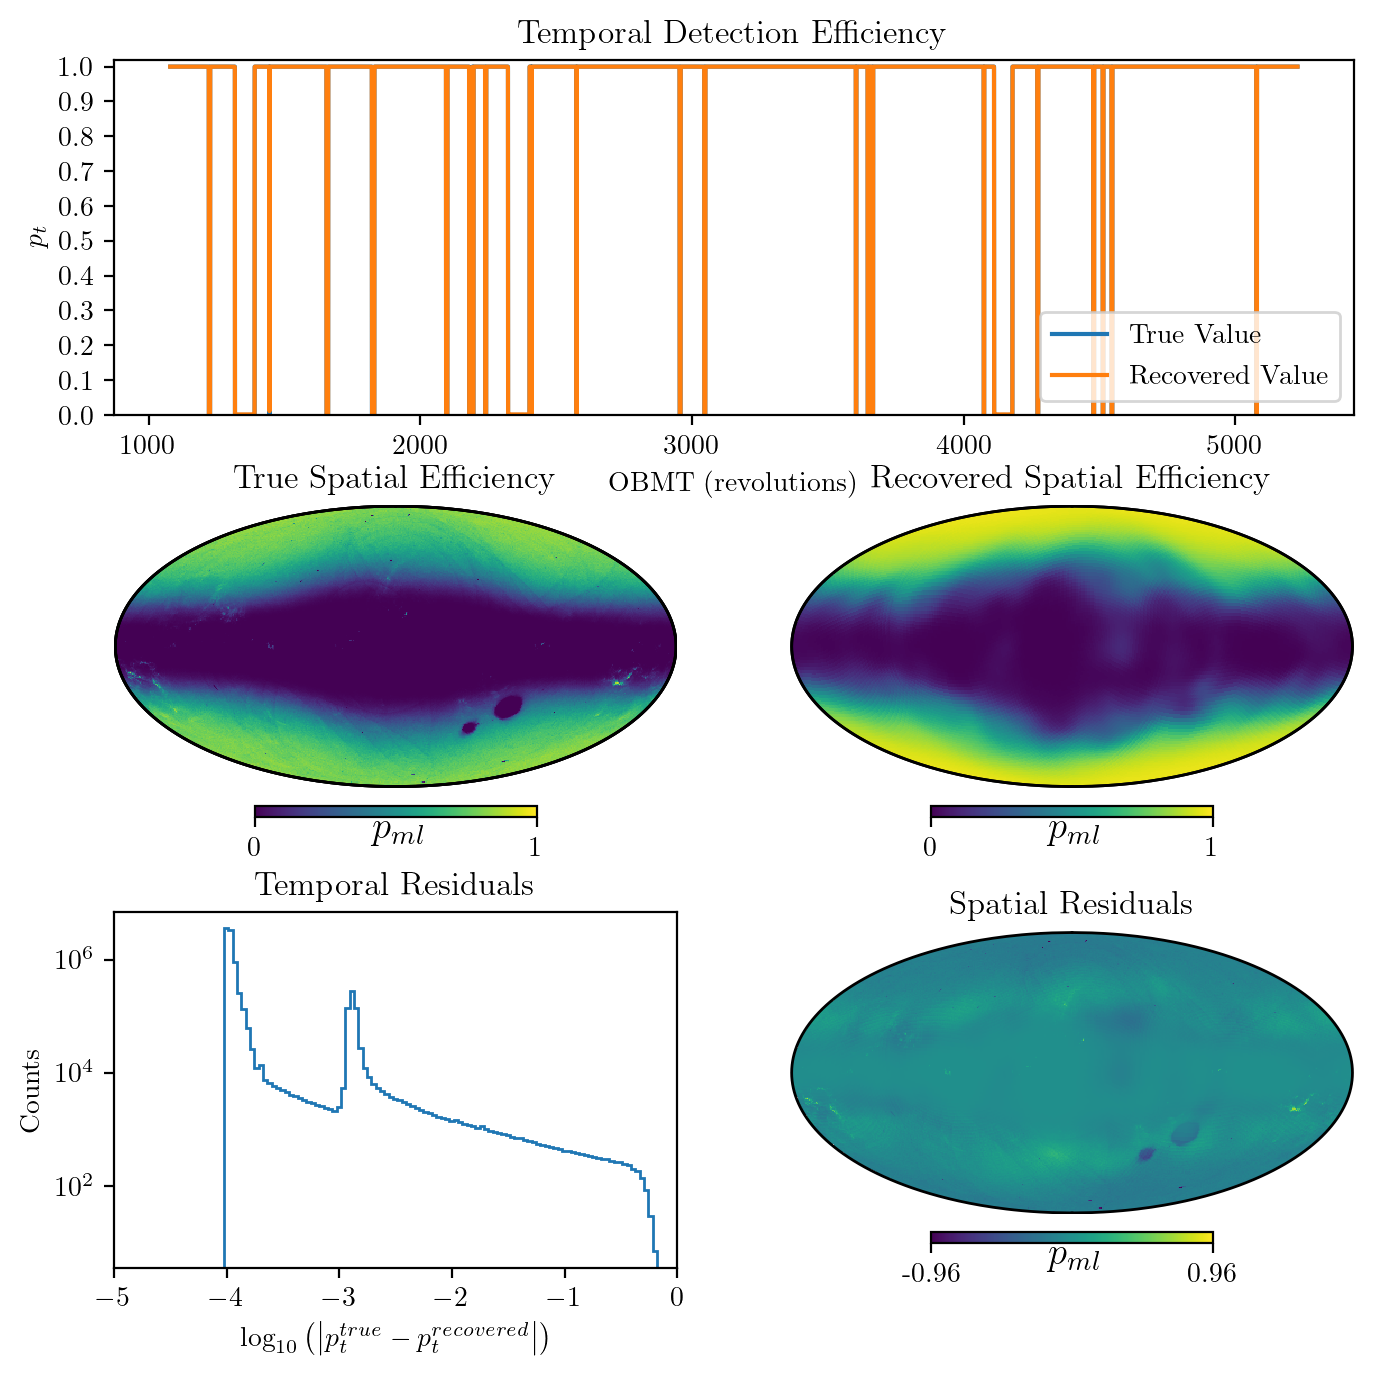

In [13]:
dataDir = "../../../Data/TestSets/full/"
directory = "../../../CodeOutput/TestRuns/full/"
final = "FinalPosition_TransformedParameters.dat"
# ~ baseGif("test",dataDir,directory,4,101,4)
baseFrame("full.png",dataDir,directory,final)